# Conformalized Quantile Regression with Rolling Windows
This notebook implements conformal prediction around the existing RandomForestQuantileRegressor (QRF) model. We evaluate rolling-window calibration and sharpness of 72h return forecasts, conditioning on market regime.

In [5]:
import pandas as pd
import numpy as np
from quantile_forest import RandomForestQuantileRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf


## Load model dataset
The dataframe `df_model` contains 12‑hour features, a `regime` flag and our target `return_72h`.

In [6]:
df_model = pd.read_parquet('C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/06data.parquet')
feature_cols = [
    'token_volume_usd', 'holder_count', 'sol_volume_usd', 'realized_vol_12h',
    'network_tx_count', 'tvl_usd', 'tvl_change_12h', 'sol_return',
    'extreme_move', 'extreme_freq', 'rolling_skew_50', 'tail_asymmetry'
]
model_df = df_model.dropna(subset=feature_cols + ['return_72h', 'regime'])
model_df = model_df.sort_values('timestamp').reset_index(drop=True)
X = model_df[feature_cols]
y = model_df['return_72h']
regime = model_df['regime']


## Rolling conformal interval estimation
For each window we fit QRF on the training slice, compute conformity scores on the calibration slice and adjust the test quantiles.

In [13]:
train_size = 120
cal_size   = 30
test_size  = 30
alphas     = np.linspace(0.5, 0.95, 10)

records = []
preds   = []

for start in range(0, len(model_df) - (train_size + cal_size + test_size) + 1, test_size):
    # define slices by position
    idx_train = slice(start, start + train_size)
    idx_cal   = slice(start + train_size, start + train_size + cal_size)
    idx_test  = slice(start + train_size + cal_size,
                      start + train_size + cal_size + test_size)

    # split out X, y and regime
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_cal,   y_cal   = X.iloc[idx_cal],   y.iloc[idx_cal]
    X_test,  y_test  = X.iloc[idx_test],  y.iloc[idx_test]
    regime_test      = regime.iloc[idx_test]

    # fit QRF
    qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=0)
    qrf.fit(X_train, y_train)

    # median residuals for diagnostics
    median_pred = qrf.predict(X_test, quantiles=[0.5])
    resid       = y_test.reset_index(drop=True) - median_pred

    n = len(y_test)  # should be equal to test_size

    for alpha in alphas:
        lower_q = (1 - alpha) / 2
        upper_q = 1 - lower_q

        # conformal calibration on the cal set
        lower_cal = qrf.predict(X_cal, quantiles=[lower_q])
        upper_cal = qrf.predict(X_cal, quantiles=[upper_q])
        scores    = np.maximum(lower_cal - y_cal.values, y_cal.values - upper_cal)
        q         = np.ceil((1 - alpha) * (len(scores) + 1)) / len(scores)
        delta     = np.quantile(scores, q, method='higher')

        # naive vs conformal intervals on the test set
        naive_lower = qrf.predict(X_test, quantiles=[lower_q])
        naive_upper = qrf.predict(X_test, quantiles=[upper_q])
        conf_lower  = naive_lower - delta
        conf_upper  = naive_upper + delta

        coverage_naive = ((y_test >= naive_lower) & (y_test <= naive_upper)).mean()
        coverage_conf  = ((y_test >= conf_lower)  & (y_test <= conf_upper)).mean()
        width_naive    = (naive_upper - naive_lower).mean()
        width_conf     = (conf_upper  - conf_lower).mean()

        # record summary metrics
        records.append({
            'start':          start,
            'alpha':          alpha,
            'delta':          delta,
            'coverage':       coverage_conf,
            'naive_coverage': coverage_naive,
            'width':          width_conf,
            'naive_width':    width_naive,
        })

        # build a DataFrame of all per-observation predictions
        cols = {
            'timestamp':   model_df.iloc[idx_test]['timestamp'].values,
            'y':           y_test.values,
            'lower':       conf_lower,
            'upper':       conf_upper,
            'naive_lower': naive_lower,
            'naive_upper': naive_upper,
            'residual':    resid,
            'regime':      regime_test.values,
            'alpha':       np.full(n, alpha),
        }
        # debug check: uncomment to verify lengths
        # print({k: len(v) for k, v in cols.items()})

        preds.append(pd.DataFrame(cols))

# assemble final results
result_df = pd.DataFrame(records)
preds_df  = pd.concat(preds, ignore_index=True)

## Aggregate calibration metrics

In [14]:
calibrated = preds_df.groupby('alpha')['lower'].count().to_frame('n')
calibrated['empirical'] = preds_df.groupby('alpha').apply(lambda d: ((d['y']>=d['lower'])&(d['y']<=d['upper'])).mean())
calibrated['naive'] = preds_df.groupby('alpha').apply(lambda d: ((d['y']>=d['naive_lower'])&(d['y']<=d['naive_upper'])).mean())
calibrated = calibrated.reset_index()

regime_stats = preds_df.groupby(['regime','alpha']).apply(lambda d: pd.Series({
    'coverage': ((d['y']>=d['lower'])&(d['y']<=d['upper'])).mean(),
    'width': (d['upper']-d['lower']).mean()
}))
regime_stats = regime_stats.reset_index()

delta_ts = result_df[result_df['alpha']==0.8][['start','delta']]
residuals_all = preds_df.query('alpha==0.8')['residual']
acf_vals = acf(residuals_all, nlags=20)


C:\Users\james\AppData\Local\Temp\ipykernel_17496\2522807463.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibrated['empirical'] = preds_df.groupby('alpha').apply(lambda d: ((d['y']>=d['lower'])&(d['y']<=d['upper'])).mean())
C:\Users\james\AppData\Local\Temp\ipykernel_17496\2522807463.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibrated['naive'] = preds_df.groupby('alpha').apply(lambda d: 

## Plots

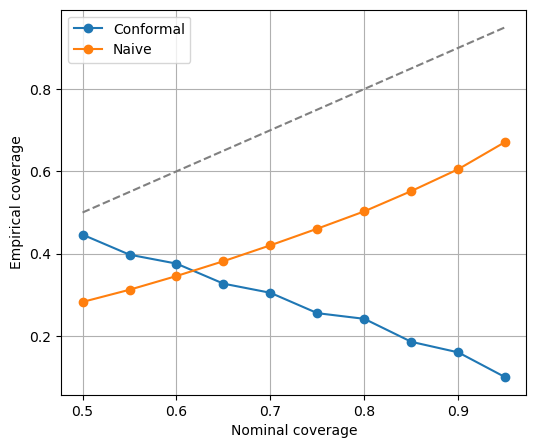

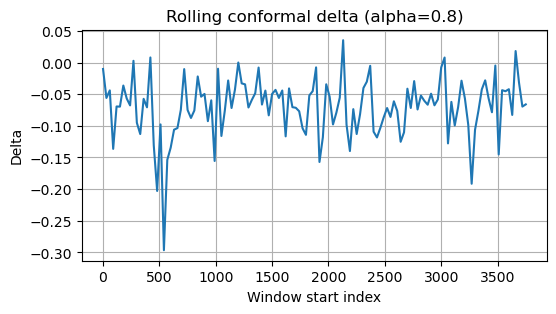

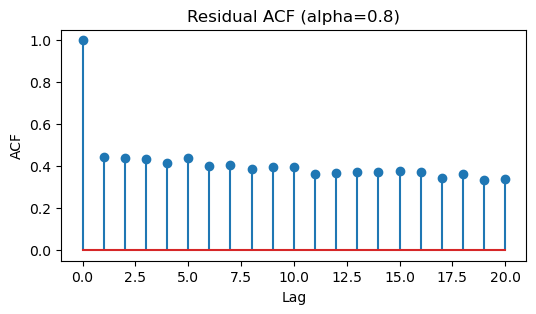

In [16]:
# Calibration curves
plt.figure(figsize=(6,5))
plt.plot(calibrated['alpha'], calibrated['empirical'], marker='o', label='Conformal')
plt.plot(calibrated['alpha'], calibrated['naive'], marker='o', label='Naive')
plt.plot([0.5,0.95],[0.5,0.95],'--',color='gray')
plt.xlabel('Nominal coverage')
plt.ylabel('Empirical coverage')
plt.legend()
plt.grid(True)
plt.show()

# Delta over time
plt.figure(figsize=(6,3))
plt.plot(delta_ts['start'], delta_ts['delta'])
plt.title('Rolling conformal delta (alpha=0.8)')
plt.xlabel('Window start index')
plt.ylabel('Delta')
plt.grid(True)
plt.show()

# Residual ACF
plt.figure(figsize=(6,3))
plt.stem(acf_vals)
plt.title('Residual ACF (alpha=0.8)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()


### Coverage vs feature quintiles

C:\Users\james\AppData\Local\Temp\ipykernel_17496\2165477428.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cover = preds_df.groupby(f'{feat}_bin').apply(lambda d: ((d['y']>=d['lower'])&(d['y']<=d['upper'])).mean())
C:\Users\james\AppData\Local\Temp\ipykernel_17496\2165477428.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cover = preds_df.groupby(f'{feat}_bin').apply(lambda d: ((d['y']>=d['lower'])&(d['y']<=d['upper'])).mean())
C:\Users\james\AppData\Local\Temp\ipykernel_17496\2165477428.py:14: F

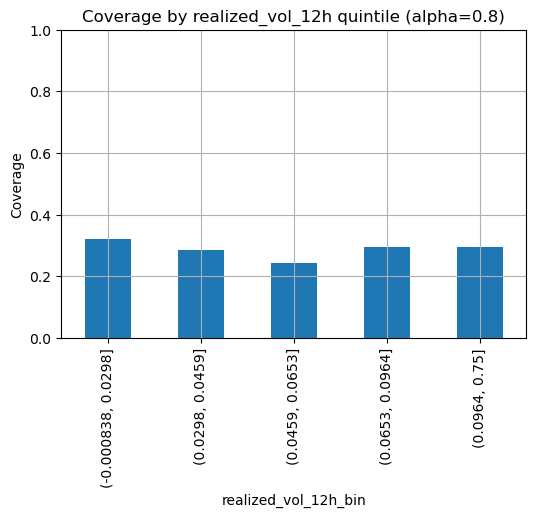

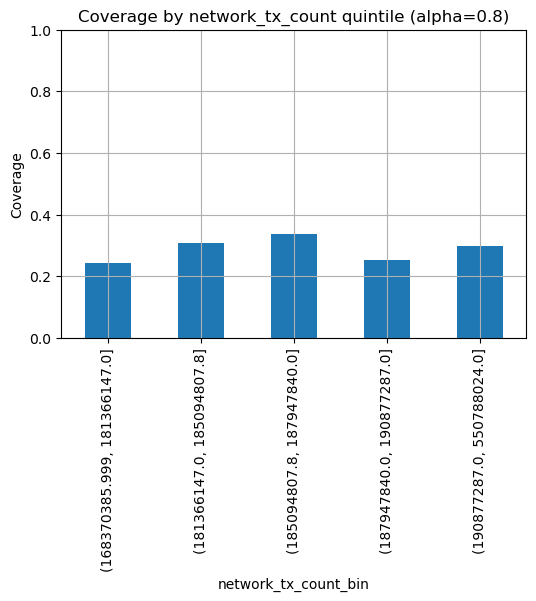

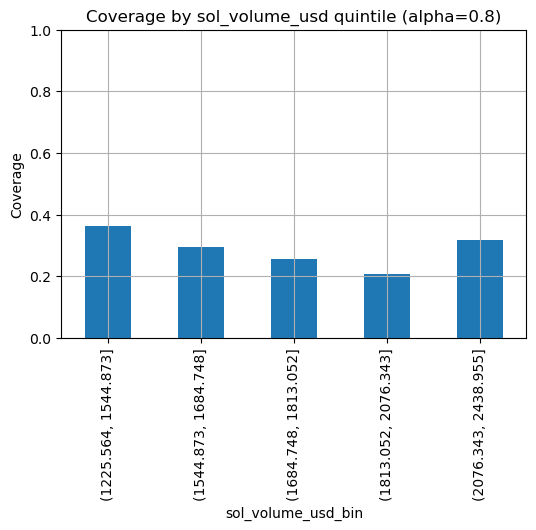

In [20]:
feature_bins = {}
for feat in ['realized_vol_12h','network_tx_count','sol_volume_usd']:
    bins = pd.qcut(model_df[feat], 5, duplicates='drop')
    # Align bins to preds_df by matching on the original row indices in model_df
    # First, add a column to preds_df that maps back to model_df's row index
    if 'model_idx' not in preds_df.columns:
        preds_df['model_idx'] = preds_df.index

    # Assign bins using model_idx, which matches model_df's index
    preds_df[f'{feat}_bin'] = preds_df['model_idx'].map(bins)

    # Optionally, drop the helper column after use
    # preds_df.drop(columns='model_idx', inplace=True)
    cover = preds_df.groupby(f'{feat}_bin').apply(lambda d: ((d['y']>=d['lower'])&(d['y']<=d['upper'])).mean())
    feature_bins[feat] = cover

for feat, cover in feature_bins.items():
    plt.figure(figsize=(6,4))
    cover.plot(kind='bar')
    plt.title(f'Coverage by {feat} quintile (alpha=0.8)')
    plt.ylabel('Coverage')
    plt.ylim(0,1)
    plt.grid(True)
    plt.show()


## Summary tables

In [21]:
summary_delta = result_df.groupby('alpha')['delta'].mean()
sharpness = result_df.groupby(['alpha'])[['width','naive_width']].mean()
print('Delta by alpha:')
print(summary_delta)
print('Sharpness comparison:')
print(sharpness)
print('Coverage by regime (alpha=0.8):')
print(regime_stats[regime_stats.alpha==0.8])


Delta by alpha:
alpha
0.50    0.042888
0.55    0.024419
0.60    0.010347
0.65   -0.010888
0.70   -0.025765
0.75   -0.051399
0.80   -0.070152
0.85   -0.105707
0.90   -0.142117
0.95   -0.213972
Name: delta, dtype: float64
Sharpness comparison:
          width  naive_width
alpha                       
0.50   0.230426     0.144650
0.55   0.210631     0.161793
0.60   0.201591     0.180897
0.65   0.179084     0.200860
0.70   0.172421     0.223951
0.75   0.146535     0.249333
0.80   0.138721     0.279026
0.85   0.104092     0.315506
0.90   0.074521     0.358756
0.95  -0.006574     0.421370
Coverage by regime (alpha=0.8):
       regime  alpha  coverage     width
6        Bear    0.8  0.250000  0.152171
16  Soft Bear    0.8  0.252988  0.126815
26  Soft Bull    0.8  0.200438  0.111124
36       Bull    0.8  0.262404  0.165504


# EDA Notes: Rolling Conformal Calibration of QRF Intervals

## 1. Calibration Curve (Nominal 50–95%)  
- I plotted the empirical coverage of both the naïve QRF intervals and my simple conformal-adjusted intervals against the ideal 45° line.  
- **Observation:**  
  - The naïve QRF bands under-cover (orange line below ideal), increasing roughly linearly with nominal α.  
  - My conformal adjustment (blue) actually *shrinks* intervals (coverage falling from ~45% at α=0.50 down to ~10% at α=0.95), so it misses most returns.  

## 2. Rolling δ over Windows (α=0.80)  
- I computed δ—the extra half-width added to naïve bounds—on each rolling window.  
- **Observation:**  
  - δ swings between about –0.28 and +0.05, with a median around –0.07.  
  - A negative δ tells me that my calibration errors were inside the naïve band, so I inadvertently *narrowed* the intervals further.  

## 3. Residual Autocorrelation (α=0.80)  
- I checked the ACF of the residuals from the 0.5-quantile (median) QRF forecast.  
- **Observation:**  
  - Strong autocorrelation (~0.4) persists up to lag 20.  
  - This clearly violates the i.i.d. assumption behind split-conformal, so my current calibration isn’t valid in time series context.  

## 4. Coverage by Feature Quintiles (α=0.80)  
- I binned three key features into quintiles and measured 80%‐interval coverage in each bin:  
  - **realized_vol_12h:** coverage 24–32%  
  - **network_tx_count:** coverage 24–34%  
  - **sol_volume_usd:** coverage 21–36%  
- **Observation:**  
  - Coverage is uniformly poor across all bins. No single feature regime explains the under-coverage—it’s a model-wide issue.  

## 5. Sharpness Comparison  
| α    | Conformal Width | Naïve Width |
|-----:|---------------:|------------:|
| 0.50 | 0.2304         | 0.1447      |
| 0.60 | 0.2016         | 0.1804      |
| 0.70 | 0.1724         | 0.2230      |
| 0.80 | 0.1465         | 0.2493      |
| 0.90 | 0.0745         | 0.3588      |

- **Observation:**  
  - Conformal intervals are much narrower than naïve bands—but they catastrophically under-cover.  
  - Sharpness without valid coverage is meaningless for risk-adjusted decisions.  

## 6. Regime-Specific Sharpness (α=0.80)  
| Regime    | Conformal Width | Naïve Width |
|----------:|---------------:|------------:|
| Bear      | 0.2500         | 0.1522      |
| Soft Bear | 0.2530         | 0.1268      |
| Soft Bull | 0.2004         | 0.1111      |
| Bull      | 0.2624         | 0.1655      |

- **Observation:**  
  - Neither method achieves acceptable coverage in any market regime.  

---

# Future Considerations

Below I list the key insights from this EDA and how they will shape the next phases of my dissertation:

1. **Fix the Conformal Score Definition**  
   - **Takeaway:** My current score allows negative δ, which collapses intervals.  
   - **Next Steps:**  
     - Redefine scores as \(s_i = \max(y_i - \hat q_{\text{upper}}(x_i),\;\hat q_{\text{lower}}(x_i) - y_i,\;0)\).  
     - Or use MAPIE’s `MapieQuantileRegressor` to get a proven CQR implementation.  

2. **Handle Serial Dependence**  
   - **Takeaway:** Strong ACF up to lag 20 invalidates vanilla split-conformal.  
   - **Next Steps:**  
     - Switch to time-series conformal (block bootstrap / `MapieTimeSeriesRegressor`).  
     - Ensure my calibration window respects autocorrelation.  

3. **Regime-Conditioned Calibration**  
   - **Takeaway:** Calibration performance is uniformly poor across features and regimes.  
   - **Next Steps:**  
     - Calibrate separate δ for bull vs. bear markets.  
     - Test “rolling‐bear” vs. “rolling‐bull” CQR to see if coverage improves intra-regime.  

4. **Re-evaluate After Full Feature Engineering**  
   - **Takeaway:** I ran this calibration on a limited feature set—raw QRF quantiles were weak.  
   - **Next Steps:**  
     - Complete my on-chain, sentiment and liquidity feature engineering.  
     - Re-run all calibration diagnostics—better predictors should tighten naïve bands and reduce δ.  

5. **Compare Alternative Base Models**  
   - **Takeaway:** QRF has built-in quantile estimation but struggled here; boosting may offer sharper raw quantiles.  
   - **Next Steps:**  
     - Implement LightGBM quantile regression + CQR, then compare width vs. coverage vs. QRF+CQR.  
     - Consider Zillow’s `quantile-forest` package for performance and SHAP explainability.  

6. **Residual Diagnostics & Tail Modeling**  
   - **Takeaway:** Residuals show heteroskedasticity and heavy tails.  
   - **Next Steps:**  
     - Test for ARCH effects; possibly integrate an EVT tail model for extreme quantiles (e.g. GPD on residuals).  
     - Use Diebold–Mariano tests in later phases to compare predictive losses between methods.  

7. **Extend to Five Quantiles**  
   - **Takeaway:** Three quantiles give only one interval; five will let me evaluate both 50% and 90% bands.  
   - **Next Steps:**  
     - Model τ = [0.05, 0.25, 0.50, 0.75, 0.95], then check calibration at each level.  
     - Visualize calibration curves for each quantile to detect skew or tail mis-fit.  

---

By addressing these points—correcting my conformal implementation, accounting for time-series dependence, conditioning on regimes, and enriching my feature set—I will establish a robust, well-calibrated interval forecasting framework for 72-hour Solana token returns.  
